# Determine redshift using machine learning

First, what is redshift and why is it important? Redshift is the equivalent to the distance of stellar objects from us. It is measured using spectroscopy and measuring the redshift (shift of the spectra to the red side of the wavelength). This is important because it allow us to calculate the actual magnitudes of the stellar objects and we can do a lot of fun science with it. Spectra data is not up to par with  the vast optical data available so it is important to have good redshifts from photometry.

The data was obtained using the skyserver from the Sloan Digital Sky Survey (SDSS) using the SQL query. In the SQL query, I specified for no missing values of the redshift or the five bands (u,g,r,i,z). Also the dered values were obtained to account for galactic extinction. There maybe a confusion between z the band and z the redshift but in this study the band will always be denoted with dered_z.

To note that SDSS removed their photozRF table because it does poorly with the faint red galaxies targeted in  Baryon Oscillation Spectroscopic Survey (BOSS). 


In [1]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import table
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set()
%matplotlib inline

## Loading data and some EDA

In [39]:
filepath= "/home/veroastro/Documents/spectraTypes/data/"
star = pd.read_csv(filepath+"STAR2_Skyserver_SQL2_12_2022 5_02_48 PM.csv")
QSO = pd.read_csv(filepath+"QSO2Skyserver_SQL2_12_2022 5_03_49 PM.csv")
galaxy = pd.read_csv(filepath+"GALAXY2Skyserver_SQL2_12_2022 5_03_24 PM.csv")

In [40]:
#Create the data frame from the three sets of data
data = pd.concat([star, QSO, galaxy])
#Scramble the data set so that it is not ordered by spectral class (QSO, galaxy or star) 
data = data.sample(frac=1)

data.head()

,#objID,type,dered_u,err_u,dered_g,err_g,dered_r,err_r,dered_i,err_i,dered_z,err_z,specObjID,z,zErr,photoZ,photoErr,zWarning,class,subClass
500,1237657586030018745,3,20.59360,0.112522,19.98190,0.027089,18.99284,0.015428,18.53046,0.013702,18.29675,0.038108,467280378701309952,0.431808,0.000026,0.282901,0.045386,0,QSO,BROADLINE
3893,1237648721763696841,3,18.62643,0.033906,17.45003,0.006801,16.92500,0.006500,16.57318,0.007134,16.35655,0.022468,315404008443373568,0.098046,0.000009,0.076147,0.018559,0,GALAXY,STARFORMING
1776,1237648721248124995,3,18.03189,0.018969,17.32984,0.005579,16.73076,0.004722,16.21448,0.004578,16.07244,0.011602,345696929033775104,0.103982,0.000030,0.163076,0.022613,0,QSO,BROADLINE
2392,1237651249891770406,3,18.92365,0.021992,18.29976,0.007196,17.68876,0.006008,17.40119,0.006040,17.39283,0.015094,678943791721244672,0.220110,0.000020,0.165601,0.036602,0,QSO,STARBURST BROADLINE
2894,1237652943695118702,3,21.95921,0.321774,18.99754,0.012317,17.75935,0.007091,17.23055,0.006586,16.90502,0.015856,820933630732822528,-0.000056,0.000009,0.193444,0.016763,0,STAR,K7


In [43]:
photozErr= data.loc[(data['photoZ'] >= 0.0)]['photoErr']
print('Mean photoError:', round(np.mean(photozErr), 3))

Mean photoError: 0.038


In [6]:
print('Mean specError:', round(np.mean(data['zErr']), 3))

Mean specError: 0.019


The mean value of the spectroscopic errors is 0.019  while the mean value of the photometric errors is 0.038.

In [7]:
data_clean = data.drop(columns=['zWarning','specObjID','#objID','err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'zErr', 'class', 'subClass', 'photoZ','photoErr','type'])
data_clean.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z
1826,20.13617,19.76059,19.42947,18.91666,18.50034,0.461495
2856,19.56304,17.58714,16.86860,16.60582,16.47174,0.000032
927,22.39862,19.75858,18.30336,17.66199,17.27338,0.000025
4541,19.31371,18.98363,18.55181,18.43749,17.95164,0.326223
2500,20.29923,19.87521,19.60703,19.18817,19.06098,0.564797


In [8]:
data_clean.describe()

,dered_u,dered_g,dered_r,dered_i,dered_z,z
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,19.869886,18.452114,17.631055,17.163975,16.934978,0.142970
std,1.702831,1.544044,1.469840,1.371121,1.453392,0.267116
min,11.101360,12.074510,10.785910,10.756660,9.813457,-0.004329
25%,18.870685,17.598865,16.818828,16.356315,16.086430,0.000060
50%,19.614630,18.316495,17.479280,17.038925,16.791815,0.093467
75%,20.553992,19.144298,18.450765,18.022543,17.732482,0.201547
max,29.762490,29.461400,28.317300,28.234270,28.220950,6.827977


In [9]:
def hist_plots( data: pd.DataFrame,
               rows: int,
              cols: int,
              figsize: tuple):
    fig, axes = plt.subplots(rows,cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(data.columns):
            data[sorted(data.columns)[i]].plot.hist(bins=30, ax=ax)
            ax.set_title(f'{sorted(data.columns)[i]} distribution', fontsize=10)
            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.get_yaxis().get_label().set_visible(False)
        else:
            fig.delaxes(ax=ax)
    fig.tight_layout()

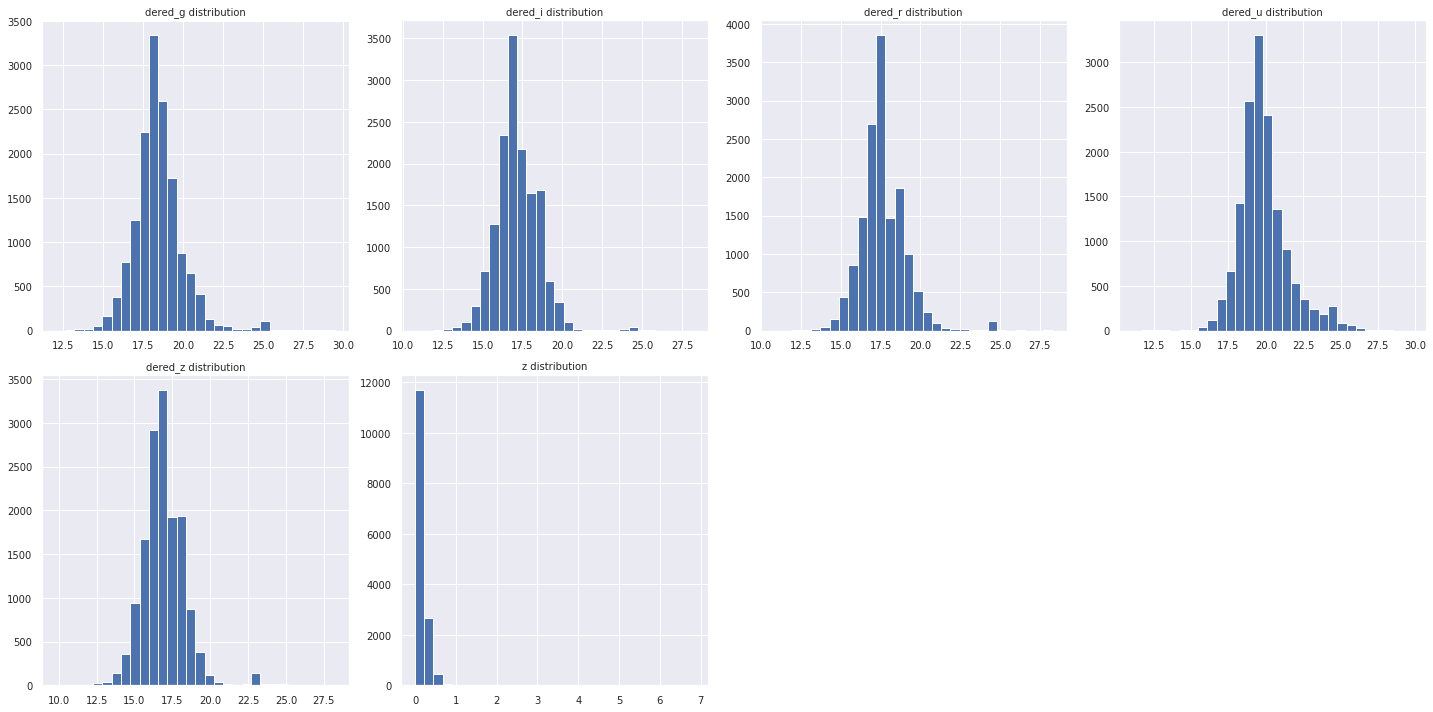

In [10]:
hist_plots(data=data_clean,
          rows=2,
          cols=4,
          figsize=(20,10))
#plt.savefig(filepath+'images/zhistplot.png')

The magnitudes of the bands are in the interquartile ranges (25-75%) between 16-18. The fainter (higher value) sources are mostly outliers of the destributions. Since the distributions are fairly bright, I decided to keep them.

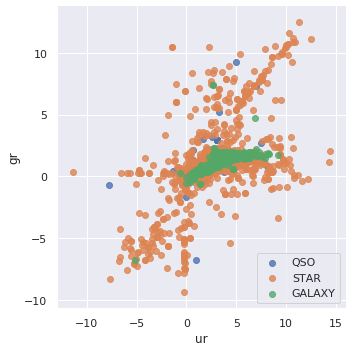

In [12]:
data['ur'] =  data['dered_u'] - data['dered_r']
data['gr'] =  data['dered_g'] - data['dered_r']
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="ur", y="gr", data=data, fit_reg=False, hue='class', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.show()

As seen by the graph above, colours (the difference in magnitude between 2 bands) gives no extra information.

In [11]:
# separating feature X and label y and normalizing data
from sklearn.preprocessing import MinMaxScaler
cols= data_clean.columns[:-1]
X = data_clean[cols]
y = data_clean['z']
scaler = MinMaxScaler()
X_t = scaler.fit_transform(X)

## Training models

In [13]:
#splitting data to train and set datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_t, y, 
                                                    test_size=0.3, random_state=42)

In [14]:
# Training Linear regression algorithm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

LR = LinearRegression()

# Storage for error values
error_df = list()


LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                           'test' : mean_squared_error(y_test,  y_test_pred)}))


In [15]:
error_df

[train    0.064382
 test     0.058936
 dtype: float64]

In [16]:
#training and predicting with Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
RF = RandomForestRegressor(random_state = 42)
param_grid = {  'bootstrap': [True],
                'max_features': ['log2'], 
                'n_estimators': range(1,400, 40)}

rf= GridSearchCV(RF,
                  param_grid=param_grid)

# Train the model on training data
rf.fit(X_train, y_train);
predictions = rf.predict(X_test)


In [17]:
rf.best_params_ ,rf.best_score_

({'bootstrap': True, 'max_features': 'log2', 'n_estimators': 161},
 0.2216411062731054)

'bootstrap': True, 'max_features': 'log2', 'n_estimators': 121 best parameters of the random forest regressor. 

In [18]:
# Print out the mean square error
print('Mean Square Error RF:', round(mean_squared_error(y_test, predictions), 3))

Mean Square Error RF: 0.049


In [19]:
photozErr= data.loc[(data['photoZ'] >= 0.0)]['photoZ']
sZ= data.loc[(data['photoZ'] >= 0.0)]['z']
print(photozErr.shape)
print('Mean Square Error SDSS:', round(mean_squared_error(sZ,photozErr), 3))

(14307,)
Mean Square Error SDSS: 0.068


The test error of the linear regression model is (mse) 0.058 while we get an mse of 0.049 with random forest regressor. To compare errors the mse from the difference between photometric redshift and spectroscopic redshift is 0.068. Here there are values of photoz of -999.0. This are the same as missing values so they are taken out of the calculation of mse.

## Adding spectral types

This is to check if it would reduce the error on the ml determined redshifts.

In [20]:
# converting class from categorical to numerical
def type_to_value(n):
    if n == 'STAR':
        return 1
    elif n == 'QSO':
        return 2
    elif n == 'GALAXY':
        return 3
    

data['nClass'] = [type_to_value(n) for n in data['class']]

In [21]:
#Adding class feature to X
X['class'] = data['nClass']
X_c= scaler.fit_transform(X) 

In [22]:
#Splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X_c, y, 
                                                    test_size=0.3, random_state=42)

In [23]:
# fit the model and predict the class
rf.fit(X_train, y_train);
predictions_class = rf.predict(X_test)

In [24]:
errors_class = abs(predictions_class - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error RF with class:', round(np.mean(errors_class), 3))

Mean Absolute Error RF with class: 0.033


The mse of the running Random Forest Regressor with class information reduces the error from 0.049 to 0.033.

## Calculating class

Errors were reduced with the spectra types. Now we check if ml determined classes can serve too.

In [44]:
# creating the new y with class as a label
cols =  X.columns[:-1]
new_X = X[cols]
new_y = X['class']
new_X.head()

,dered_u,dered_g,dered_r,dered_i,dered_z
1826,20.13617,19.76059,19.42947,18.91666,18.50034
2856,19.56304,17.58714,16.86860,16.60582,16.47174
927,22.39862,19.75858,18.30336,17.66199,17.27338
4541,19.31371,18.98363,18.55181,18.43749,17.95164
2500,20.29923,19.87521,19.60703,19.18817,19.06098


In [26]:
# Separating the data into train and test sets
from sklearn.model_selection import StratifiedShuffleSplit

strat_shuf_split = StratifiedShuffleSplit(n_splits=3, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(new_X,new_y))


X_train_cl = new_X.iloc[train_idx]
y_train_cl = new_y.iloc[train_idx]
X_test_cl  = new_X.iloc[test_idx]
y_test_cl  = new_y.iloc[test_idx]

In [27]:
#normalizing the data
X_train_cl= scaler.fit_transform(X_train_cl) 
X_test_cl= scaler.transform(X_test_cl)

In [28]:
#Running Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



RF = RandomForestClassifier(n_estimators = 341,
                            oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)


rfc = RF.fit(X_train_cl, y_train_cl)

In [29]:
# Class prediction and error estimation of the classifission
from sklearn.metrics import classification_report

y_pred_rf = rfc.predict(X_test_cl)
cr = classification_report(y_test_cl, y_pred_rf)
print(cr)

              precision    recall  f1-score   support

           1       0.91      0.90      0.91      1500
           2       0.94      0.88      0.91      1500
           3       0.85      0.90      0.87      1500

    accuracy                           0.89      4500
   macro avg       0.90      0.89      0.90      4500
weighted avg       0.90      0.89      0.90      4500



In [30]:
# assigning to y_class the predictions of the model
y_class = rfc.predict(new_X)
y_class.shape

(15000,)

In [31]:
#Dropping the class feature and adding the prediced class
X_class = X.drop(['class'], axis =1)
X_class['nclass'] = y_class
X_class.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,nclass
1826,20.13617,19.76059,19.42947,18.91666,18.50034,1
2856,19.56304,17.58714,16.86860,16.60582,16.47174,1
927,22.39862,19.75858,18.30336,17.66199,17.27338,1
4541,19.31371,18.98363,18.55181,18.43749,17.95164,1
2500,20.29923,19.87521,19.60703,19.18817,19.06098,1


In [33]:
#new X and y with the class information
X_train_cc = X_class.iloc[train_idx]
y_train_cc = y.iloc[train_idx]
X_test_cc  = X_class.iloc[test_idx]
y_test_cc  = y.iloc[test_idx]

X_train_cc= scaler.fit_transform(X_train_cc) 
X_test_cc= scaler.transform(X_test_cc)

In [38]:
# fit the random forest to the X with the predicted class
rf.fit(X_train_cc, y_train_cc);
predictions_c = rf.predict(X_test_cc)



ValueError: Unknown label type: 'continuous'

In [35]:
# Print out the mean square error between predicted and spectroscopic z
print('Mean Square Error RF with estimated class:', round(mean_squared_error(y_test, predictions_c), 3))

Mean Square Error RF with estimated class: 0.089


In [36]:
rf.best_params_ ,rf.best_score_

({'bootstrap': True, 'max_features': 'log2', 'n_estimators': 361},
 0.22539965066171508)

## Conclusion

I was able to improve on the accuracy of the SDSS photometric redshift slightly; 0.053 against the 0.068 of the SDSS. Also to note is that the redshift was calculated for all 15000 sources. The SDSS has photometry for 14307 of those 15000.

Using the spectra clasification, the means square error was reduced to 0.034. But using estimated classes yielded an error of 0.089. 

Better estimation of the classes might help reduce the errors on the estimation of redshifts. Also, once since missing from my estimated redshift is an estimation of the errors without the use of the spectral redshift.